# Índice

1. [Preparación y Limpieza de los Datos](#preparación-y-limpieza-de-los-datos)
2. [Matriz de Correlación](#matriz-de-correlación)
3. [Definición de Predictores y Objetivos](#definición-de-predictores-y-objetivos)
4. [Normalización y Separación de los Datos](#normalización-y-separación-de-los-datos)
5. [Definición y Configuración de los Modelos](#definición-y-configuración-de-los-modelos)
6. [Optimización, Evaluación y Comparación de Modelos](#optimización-evaluación-y-comparación-de-modelos)


imports
- pandas
- numpy
- seaborn
- matplotlib
- sklearn
- warnings 

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Preparación y Limpieza de los Datos 

Se realizaron diversas tareas de preparación y limpieza de datos utilizando un archivo de calidad del aire como fuente principal. A continuación, se describen los pasos ejecutados:

## Carga de los Datos
- Los datos se importaron desde un archivo CSV con un delimitador de punto y coma (`;`).

## Conversión de Fechas y Horas
- Las fechas se transformaron al formato estándar para su análisis (`día/mes/año`) y se gestionaron posibles errores en la conversión.
- Se derivaron nuevas variables a partir de las fechas, como el día, mes y año.
- Las horas también se transformaron al formato adecuado para facilitar su uso.

## Mapeo de Días de la Semana
- Se creó una variable que identifica el día de la semana, asociando cada día con un número (por ejemplo, 0 para lunes, 1 para martes, y así sucesivamente).

## Clasificación por Periodos del Día
- Según la hora registrada, se categorizó cada observación en tres periodos del día:
  - **Día**: Entre las 6:00 y las 12:00.
  - **Tarde**: Entre las 12:00 y las 18:00.
  - **Noche**: Resto del tiempo.

## Corrección de Datos Numéricos
- En columnas con valores numéricos que estaban representados con comas en lugar de puntos decimales, se realizaron las conversiones necesarias para interpretar correctamente los datos como números flotantes.
- Además, las columnas numéricas se revisaron para convertirlas a enteros si no contenían valores decimales.

## Configuración de Visualización
- Se ajustó la configuración de la salida para que no se muestren decimales en los números cuando no es necesario, mejorando la legibilidad de los datos.

## Eliminación de Datos Irrelevantes o Incompletos
- Se eliminaron columnas innecesarias que no aportaban valor al análisis.
- También se eliminaron las filas donde todos los valores eran nulos (`NaN`) para limpiar el conjunto de datos.

## Revisión Final de los Datos
- Se verificaron los tipos de datos de cada columna y se imprimieron los primeros registros del conjunto de datos limpio, asegurando que la estructura resultante sea adecuada para el análisis.

Este proceso garantiza que los datos sean precisos, consistentes y adecuados para el análisis posterior, como la visualización, el modelado predictivo o la generación de estadísticas descriptivas.


In [26]:
# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Categorizar por partes del día
def time_to_period(hour):
    if 6 <= hour < 12:
        return 0 #Día
    elif 12 <= hour < 18:
        return 1 #Tarde
    else:
        return 2 #Noche

df['PeriodoDia'] = df['Time'].apply(lambda t: time_to_period(t.hour) if pd.notnull(t) else None)

# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)

# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')
# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df_cleaned = df.dropna()

# Mostrar información y primeros registros
print("Tipos de datos:")
print(df_cleaned.dtypes)
print("\nPrimeros registros:")
print(df_cleaned.head())

Tipos de datos:
Date             datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)               Int64
NMHC(GT)                  Int64
C6H6(GT)                float64
PT08.S2(NMHC)             Int64
NOx(GT)                   Int64
PT08.S3(NOx)              Int64
NO2(GT)                   Int64
PT08.S4(NO2)              Int64
PT08.S5(O3)               Int64
T                       float64
RH                      float64
AH                      float64
Dia                       Int64
Mes                       Int64
Anio                      Int64
DiaSemana                 Int64
PeriodoDia                Int64
dtype: object

Primeros registros:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            939      131   
3 2004-03-10     

Limpieza de Datos

In [25]:
import pandas as pd
import numpy as np

# Columnas a imputar (excepto 'NMHC(GT)')
imputar_nan = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 
               'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
               'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Eliminar la columna 'NMHC(GT)'
df = df.drop(columns=['NMHC(GT)'], errors='ignore')

# Convertir columnas a tipo float para evitar problemas de tipo de dato
df[imputar_nan] = df[imputar_nan].astype(float)

# Reemplazar valores -200 con NaN en las columnas seleccionadas
df[imputar_nan] = df[imputar_nan].replace(-200, np.nan)

# Revisión inicial de valores faltantes
print("Valores faltantes por columna antes de imputación:")
print(df[imputar_nan].isnull().sum())

Valores faltantes por columna antes de imputación:
CO(GT)           1797
C6H6(GT)          480
NOx(GT)          1753
NO2(GT)          1756
PT08.S1(CO)       480
PT08.S2(NMHC)     480
PT08.S3(NOx)      480
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
dtype: int64


# Matriz de Correlación
Es una tabla que muestra el coeficiente de correlación entre cada par de variables numéricas en nuestro conjunto de datos. El coeficiente de correlación, que puede variar entre -1 y 1, indica la fuerza y la dirección de la relación entre dos variables:

- **Valores cercanos a 1**: Correlación positiva fuerte (a medida que una variable aumenta, la otra también).
- **Valores cercanos a -1**: Correlación negativa fuerte (a medida que una variable aumenta, la otra disminuye).
- **Valores cercanos a 0**: No hay correlación significativa.

# Matriz de Correlación Imputación con la media 

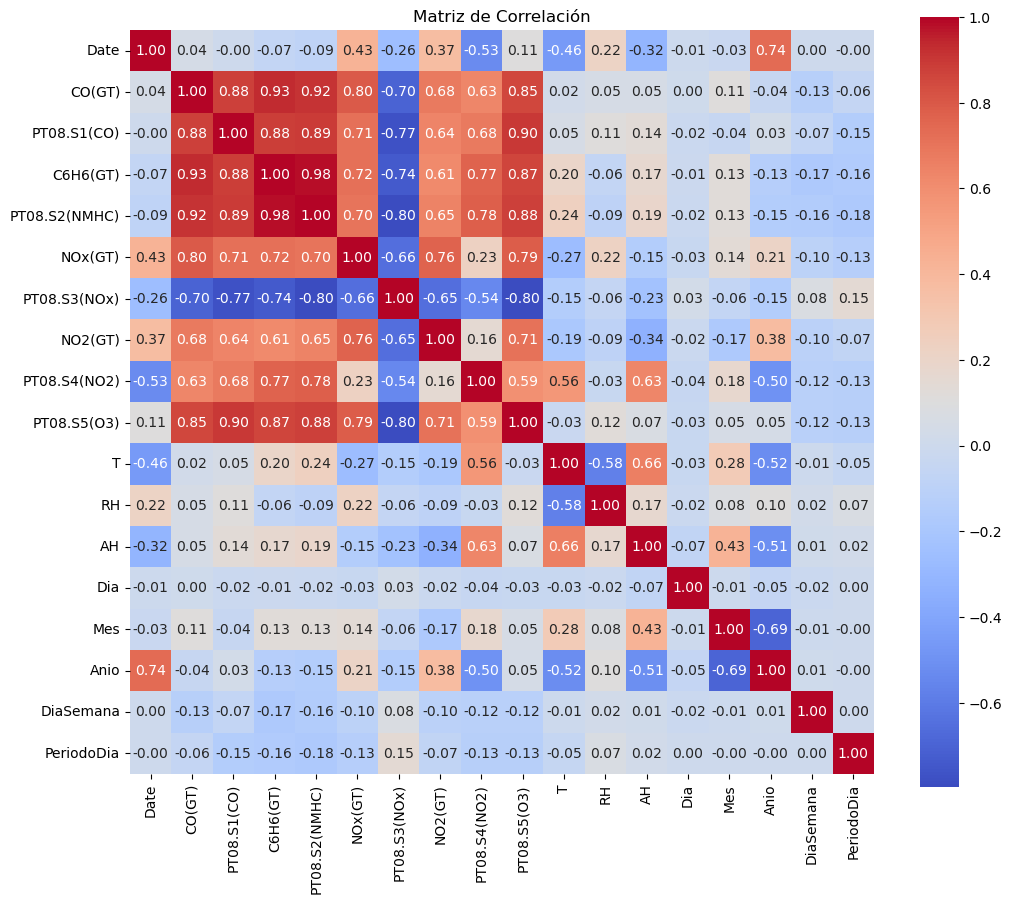

In [22]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
# 1. Imputación con la media
df_mean_imputed = df.copy()
df_mean_imputed[imputar_nan] = df_mean_imputed[imputar_nan].fillna(df_mean_imputed[imputar_nan].mean())

# 2. Imputación con la mediana
df_median_imputed = df.copy()
df_median_imputed[imputar_nan] = df_median_imputed[imputar_nan].fillna(df_median_imputed[imputar_nan].median())

FALTAN OUTLIERS 

# Definición de Predictores y Objetivos

En este paso, se definen las variables predictoras y las variables objetivo que se utilizarán en el análisis o modelado.

## ¿Qué son los Predictores?
- Los **predictores** son las variables independientes, también conocidas como **features** o características.
- Representan los datos que se utilizarán como entrada para realizar predicciones.
- En este caso, los predictores seleccionados son:
  - **T**: Temperatura.
  - **RH**: Humedad relativa.
  - **AH**: Humedad absoluta.

## ¿Qué son los Objetivos?
- Los **objetivos** son las variables dependientes o **targets**.
- Representan los valores que queremos predecir o explicar utilizando los predictores.
- En este caso, los objetivos seleccionados son:
  - **PT08.S1(CO)**: Concentración medida por un sensor relacionado con CO (monóxido de carbono).
  - **PT08.S2(NMHC)**: Concentración medida por un sensor relacionado con compuestos no metánicos (NMHC).
  - **PT08.S3(NOx)**: Concentración medida por un sensor relacionado con óxidos de nitrógeno (NOx).
  - **PT08.S4(NO2)**: Concentración medida por un sensor relacionado con dióxido de nitrógeno (NO2).

## División en Variables Predictoras y Objetivo
- Las variables se dividen en dos conjuntos principales:
  - `X`: Contiene las variables predictoras, seleccionadas de las columnas del conjunto de datos limpio (`df_cleaned`) correspondientes a **T**, **RH** y **AH**.
  - `y`: Contiene las variables objetivo, seleccionadas de las columnas correspondientes a los sensores mencionados.

Esta separación es esencial para entrenar modelos predictivos, ya que `X` proporciona la información utilizada para hacer predicciones, y `y` se usa como referencia para evaluar la precisión del modelo.


In [16]:
# Definir predictores y objetivos
predictors = ['T', 'RH', 'AH']

targets = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']


X = df_zero_imputed[predictors]
y = df_zero_imputed[targets]


# Normalización y Separación de los Datos
En este paso, se realizan dos tareas fundamentales para preparar los datos para su uso en un modelo de aprendizaje automático: **normalización** y **división en conjuntos de entrenamiento y prueba**.

## Normalización
La normalización es un proceso que ajusta los valores de las variables predictoras para que estén dentro de un rango común, generalmente entre 0 y 1. Esto es especialmente importante cuando las variables tienen escalas muy diferentes, ya que ayuda a que los modelos de aprendizaje automático converjan más rápido y de manera más eficiente.

### ¿Cómo se realizó la normalización?
1. Se utilizó el objeto `MinMaxScaler` de la biblioteca `sklearn`, que escala cada característica a un rango entre 0 y 1.
2. El método `fit_transform` se aplicó a las variables predictoras (`X`), ajustando los datos al rango deseado y transformándolos en consecuencia.
3. El resultado, almacenado en `X_scaled`, es una versión escalada de las variables predictoras.


## División en Conjuntos de Entrenamiento y Prueba
Después de la normalización, los datos se dividen en dos subconjuntos:
- **Conjunto de entrenamiento**: Se utiliza para entrenar el modelo.
- **Conjunto de prueba**: Se utiliza para evaluar el rendimiento del modelo con datos que no ha visto antes.

### ¿Cómo se realizó la división?
1. Se utilizó la función `train_test_split` de `sklearn`:
   - `X_scaled`: Variables predictoras ya normalizadas.
   - `y`: Variables objetivo.
2. Se especificó una proporción del 20% para el conjunto de prueba (`test_size=0.2`), lo que significa que el 80% de los datos se utilizarán para el entrenamiento y el 20% para la validación.
3. El argumento `random_state=42` asegura que la división sea reproducible, permitiendo obtener los mismos resultados en ejecuciones futuras.

### Resultado de la división:
- **`X_train` y `y_train`**: Datos de entrenamiento (80% del total).
- **`X_test` y `y_test`**: Datos de prueba (20% del total).


### Importancia de estos pasos
1. **Normalización**: Ayuda a mejorar el rendimiento de los modelos al garantizar que todas las variables estén en la misma escala.
2. **División en conjuntos de entrenamiento y prueba**: Permite evaluar el modelo de manera justa con datos que no ha visto durante el entrenamiento, evitando el sobreajuste.


In [17]:
# normalización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Separar datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Definición y Configuración de los Modelos

En esta sección, se define una variedad de modelos de regresión y sus respectivos hiperparámetros para realizar experimentos y comparar su rendimiento.

## Modelos Incluidos
Se seleccionaron diferentes algoritmos de regresión que cubren múltiples enfoques y técnicas.

1. **Regresión Lineal (Linear Regression)**:
   - Modelo simple basado en la relación lineal entre las variables predictoras y el objetivo.
   - No requiere hiperparámetros.

2. **Árbol de Decisión (Decision Tree Regressor)**:
   - Modelo basado en divisiones secuenciales de los datos según características relevantes.
   - Hiperparámetros:
     - `max_depth`: Profundidad máxima del árbol.
     - `min_samples_split`: Número mínimo de muestras necesarias para dividir un nodo.

3. **Bosque Aleatorio (Random Forest Regressor)**:
   - Ensamble de múltiples árboles de decisión que promedian los resultados para mejorar la precisión.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el bosque.
     - `max_depth`: Profundidad máxima de los árboles.
     - `min_samples_split`: Requisito mínimo de muestras para dividir nodos.

4. **Gradient Boosting Regressor**:
   - Modelo de ensamble que ajusta secuencialmente árboles para minimizar el error residual.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el ensamble.
     - `learning_rate`: Tasa de aprendizaje que controla el impacto de cada árbol.
     - `max_depth`: Profundidad máxima de los árboles.

5. **Regresor de Vectores de Soporte (Support Vector Regressor - SVR)**:
   - Modelo que encuentra un hiperplano en un espacio dimensional alto para realizar predicciones.
   - Hiperparámetros:
     - `C`: Penalización de errores (regularización).
     - `kernel`: Tipo de núcleo para transformar los datos (e.g., `linear`, `rbf`).
     - `epsilon`: Margen de tolerancia alrededor del hiperplano.

6. **XGBoost Regressor**:
   - Modelo avanzado basado en gradient boosting que incluye optimizaciones de regularización.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles.
     - `learning_rate`: Tasa de aprendizaje.
     - `max_depth`: Profundidad máxima de los árboles.
     - `subsample`: Fracción de datos utilizada en cada iteración.

7. **Red Neuronal (Neural Network - MLPRegressor)**:
   - Modelo inspirado en la estructura del cerebro humano, útil para capturar relaciones no lineales complejas.
   - Hiperparámetros:
     - `hidden_layer_sizes`: Configuración del número de neuronas en cada capa oculta.
     - `activation`: Función de activación (`relu`, `tanh`).
     - `solver`: Algoritmo de optimización (`adam`, `sgd`).
     - `learning_rate`: Estrategia para ajustar la tasa de aprendizaje (`constant`, `adaptive`).


## Configuración de los Modelos
- Cada modelo se define junto con un conjunto de posibles valores para sus hiperparámetros, organizados en un diccionario llamado `param_grids`.
- Este diccionario permite automatizar la búsqueda de combinaciones óptimas de hiperparámetros mediante técnicas como la búsqueda en malla (grid search) o búsqueda aleatoria (random search).

## Resultados
- Se crea un diccionario vacío llamado `results` que será utilizado para almacenar los resultados de cada modelo y las combinaciones de hiperparámetros evaluados.
- Esto facilita la comparación y selección del modelo más adecuado según los datos y la métrica de evaluación seleccionada.

### Importancia de este Enfoque
1. **Diversidad de Modelos**:
   - Permite probar múltiples enfoques para identificar el más adecuado para el problema.
   
2. **Optimización de Hiperparámetros**:
   - La configuración de hiperparámetros es clave para maximizar el rendimiento de cada modelo.

3. **Flexibilidad**:
   - Facilita la experimentación y la posibilidad de extender el análisis a otros algoritmos en el futuro.



In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Definir modelos y sus hiperparámetros
param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

results = {}


# Optimización, Evaluación y Comparación de Modelos
En esta sección, se lleva a cabo la optimización de hiperparámetros, el entrenamiento y la evaluación de diferentes modelos de regresión para cada variable objetivo. Además, se visualizan los resultados y se analizan métricas clave como el MSE, el R² y el sobreajuste.

## Optimización de Hiperparámetros
1. **Selección de Variable Objetivo**:
   - Cada modelo se entrena y evalúa individualmente para cada una de las variables objetivo definidas anteriormente (e.g., `PT08.S1(CO)`).

2. **Configuración de `GridSearchCV`**:
   - Se utiliza `GridSearchCV` para realizar una búsqueda exhaustiva de las mejores combinaciones de hiperparámetros para cada modelo.
   - Configuraciones clave:
     - `cv=5`: Validación cruzada con 5 particiones.
     - `scoring='neg_mean_squared_error'`: Métrica de evaluación basada en el MSE.
     - `n_jobs=-1`: Uso de todos los núcleos disponibles para acelerar el proceso.

3. **Entrenamiento y Selección del Mejor Modelo**:
   - Para cada combinación de hiperparámetros, `GridSearchCV` ajusta el modelo y evalúa su desempeño.
   - Se selecciona el modelo con el menor error cuadrático medio (MSE).

## Evaluación de los Modelos
1. **Predicciones**:
   - Los modelos seleccionados generan predicciones para los conjuntos de entrenamiento y prueba.
2. **Cálculo de Métricas**:
   - **MSE** (Mean Squared Error):
     - Mide el promedio de los errores al cuadrado.
     - Cuanto menor sea el valor, mejor es el modelo.
   - **R²** (Coeficiente de Determinación):
     - Indica la proporción de la varianza explicada por el modelo.
     - Valores más cercanos a 1 indican mejor desempeño.
3. **Análisis de Sobreajuste**:
   - Se calcula la diferencia entre el R² de entrenamiento y el de prueba para medir el nivel de sobreajuste.

## Almacenamiento y Visualización de Resultados
### Resultados Consolidados
- Se crea un DataFrame (`results_df`) que organiza los resultados de cada modelo y variable objetivo:
  - Métricas de entrenamiento y prueba (MSE y R²).
  - Hiperparámetros seleccionados.
  - Diferencia entre R² de entrenamiento y prueba (indicador de sobreajuste).

### Visualizaciones
1. **Nivel de Sobreajuste**:
   - Gráfico de barras que muestra la diferencia entre el R² de entrenamiento y prueba para cada modelo y variable objetivo.
   - Ayuda a identificar modelos que podrían estar ajustando en exceso los datos de entrenamiento.

2. **Comparación de R²**:
   - Gráfico de barras que compara el R² de prueba de cada modelo para cada variable objetivo.
   - Permite identificar qué modelos explican mejor la varianza de los datos.

3. **Comparación de MSE**:
   - Gráfico de barras que muestra los valores de MSE de prueba para cada modelo y variable objetivo.
   - Los valores más bajos indican un mejor desempeño.

## Importancia del Análisis
1. **Optimización Eficiente**:
   - `GridSearchCV` permite probar combinaciones de hiperparámetros de manera eficiente y sistemática.
   
2. **Evaluación Completa**:
   - El uso de múltiples métricas (MSE y R²) proporciona una evaluación integral del desempeño de los modelos.

3. **Detección de Sobreajuste**:
   - El análisis de sobreajuste garantiza que los modelos seleccionados generalicen bien a datos no vistos.

4. **Visualización Intuitiva**:
   - Los gráficos facilitan la comparación de modelos y métricas clave, ayudando en la toma de decisiones.


Optimización de hiperparámetros para el objetivo: PT08.S1(CO)
Linear Regression mejor MSE: 51026.2092, R2: 0.4881, Hiperparámetros: {}
Decision Tree mejor MSE: 43692.6792, R2: 0.5617, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10}
Random Forest mejor MSE: 40890.2074, R2: 0.5898, Hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting mejor MSE: 41236.9959, R2: 0.5863, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Support Vector Regressor mejor MSE: 43767.4450, R2: 0.5609, Hiperparámetros: {'C': 10, 'epsilon': 1, 'kernel': 'rbf'}
XGBoost mejor MSE: 41330.6121, R2: 0.5854, Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Neural Network mejor MSE: 42971.9674, R2: 0.5689, Hiperparámetros: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}

Optimización de hiperparámetros para el objetivo: PT08.S2(NMHC)
Linear Reg

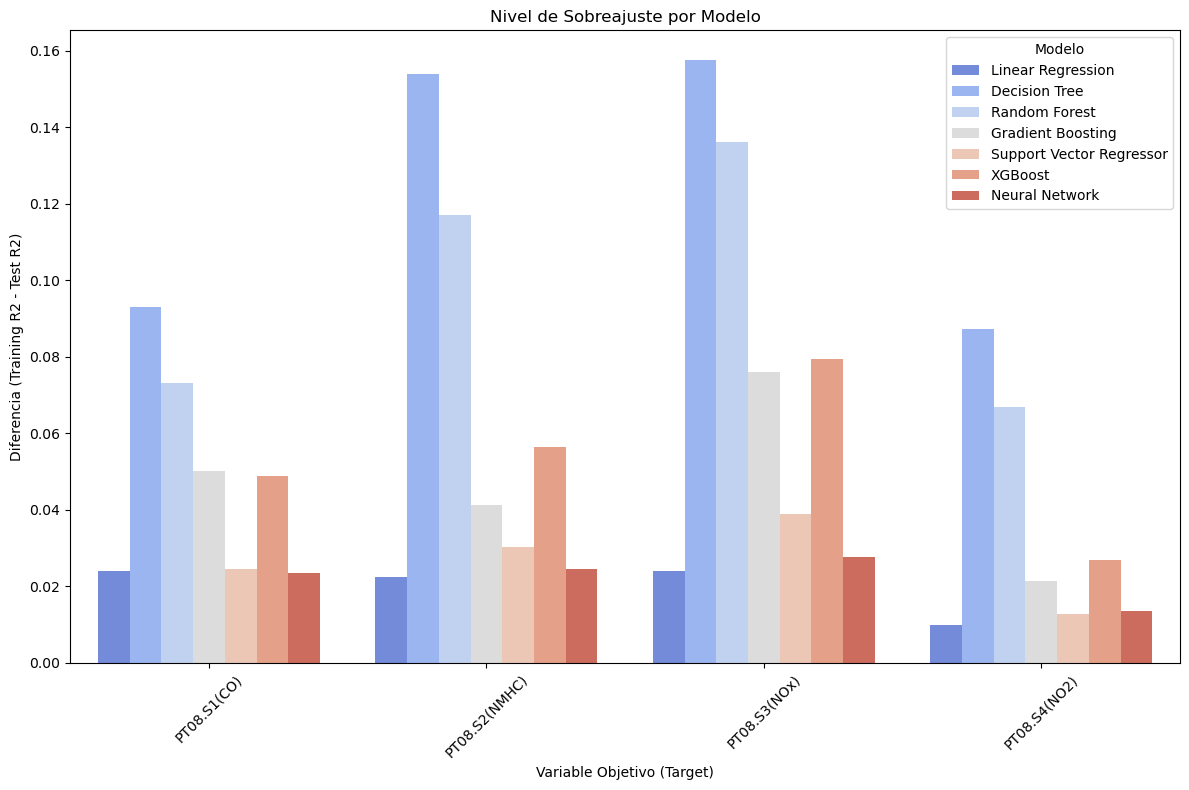

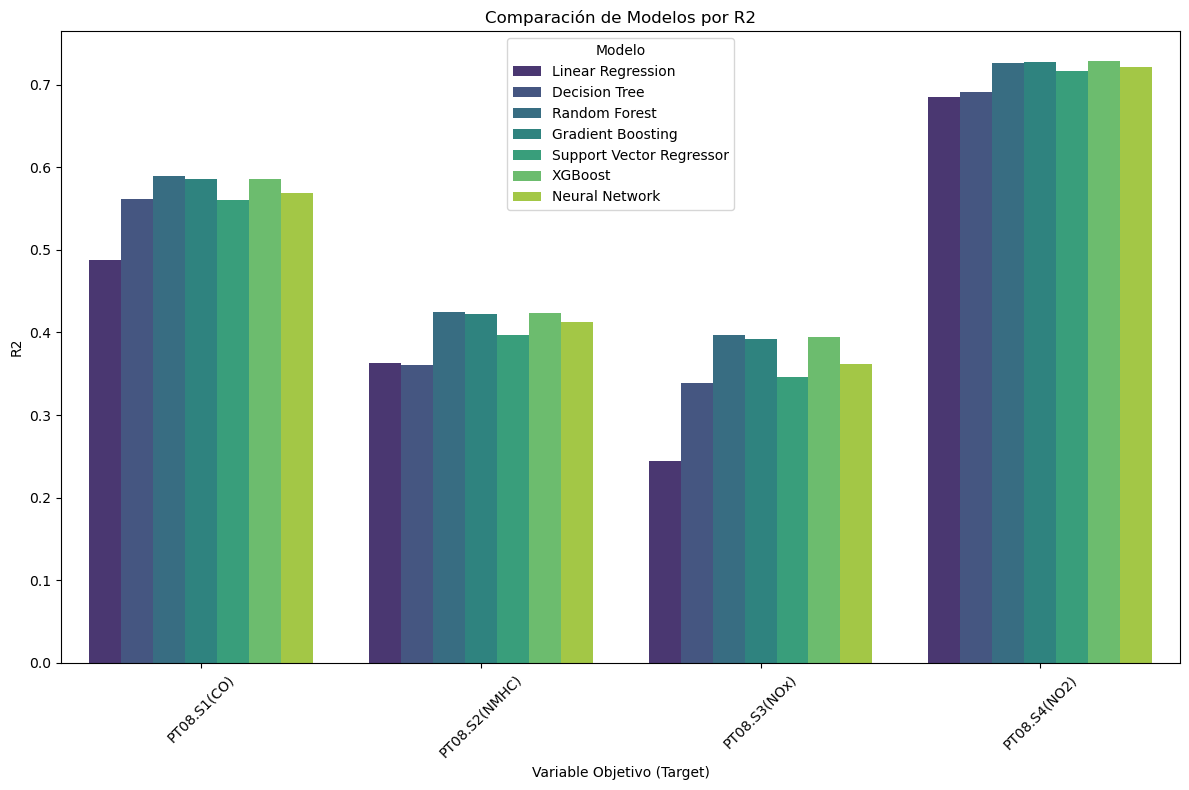

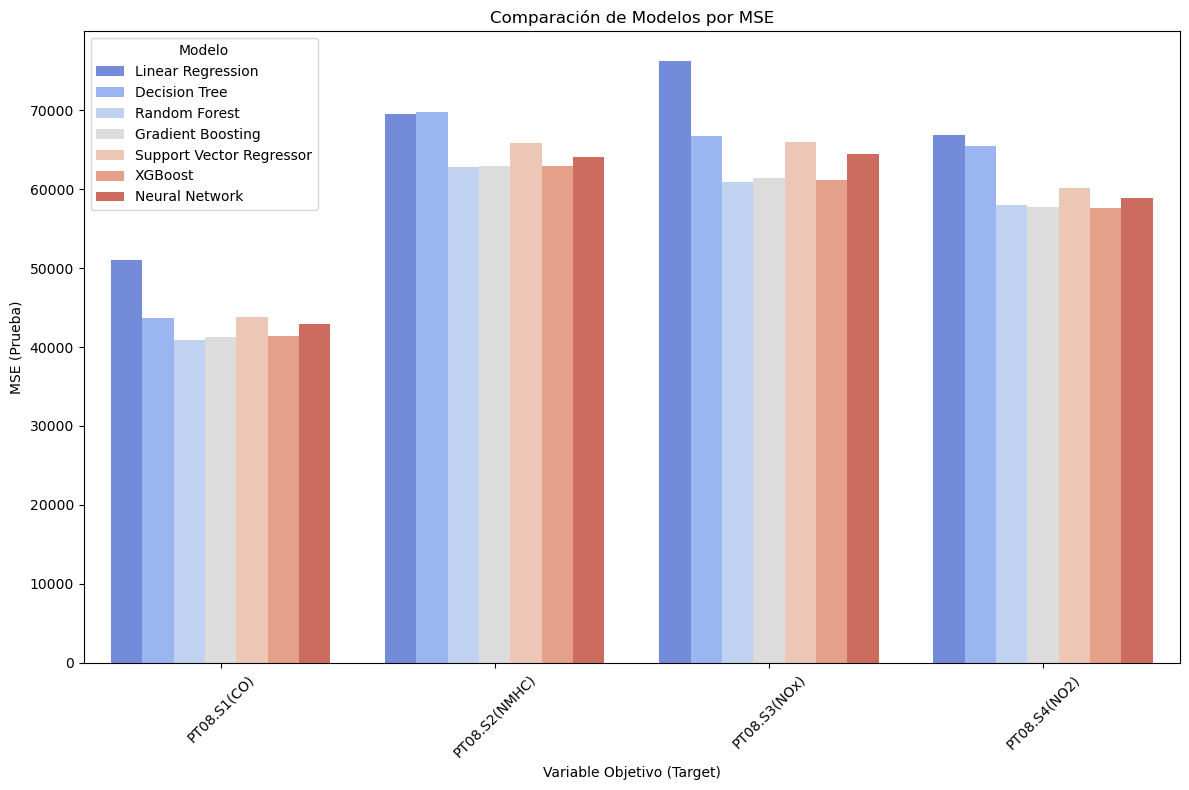

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


# Entrenar y evaluar cada modelo por variable objetivo
for target in targets:
    print(f"\nOptimización de hiperparámetros para el objetivo: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    results[target] = {}
    
    for name, config in param_grids.items():
        model = config['model']
        params = config['params']
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train_target)
        
        # Mejor modelo y evaluación
        best_model = grid_search.best_estimator_
        
        # Predicciones en entrenamiento y prueba
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calcular métricas
        mse_train = mean_squared_error(y_train_target, y_train_pred)
        mse_test = mean_squared_error(y_test_target, y_test_pred)
        r2_train = r2_score(y_train_target, y_train_pred)
        r2_test = r2_score(y_test_target, y_test_pred)
        
        # Guardar resultados
        results[target][name] = {
            'Best Params': grid_search.best_params_,
            'MSE Train': mse_train,
            'MSE Test': mse_test,
            'R2 Train': r2_train,
            'R2': r2_test  # R2 de prueba
        }
        print(f"{name} mejor MSE: {mse_test:.4f}, R2: {r2_test:.4f}, Hiperparámetros: {grid_search.best_params_}")

# Crear un DataFrame con los resultados finales
rows = []
for target, metrics in results.items():
    for name, scores in metrics.items():
        rows.append({
            'Target': target,
            'Model': name,
            'MSE Train': scores['MSE Train'],
            'MSE Test': scores['MSE Test'],
            'R2 Train': scores['R2 Train'],
            'R2': scores['R2'],
            'Overfitting': scores['R2 Train'] - scores['R2'],  # Calcular sobreajuste
            'Best Params': scores['Best Params']
        })

results_df = pd.DataFrame(rows)

# Mostrar la tabla de resultados
print("Resultados Finales:")
print(results_df)



ver graficos de R2, MSE y Sobreajuste 

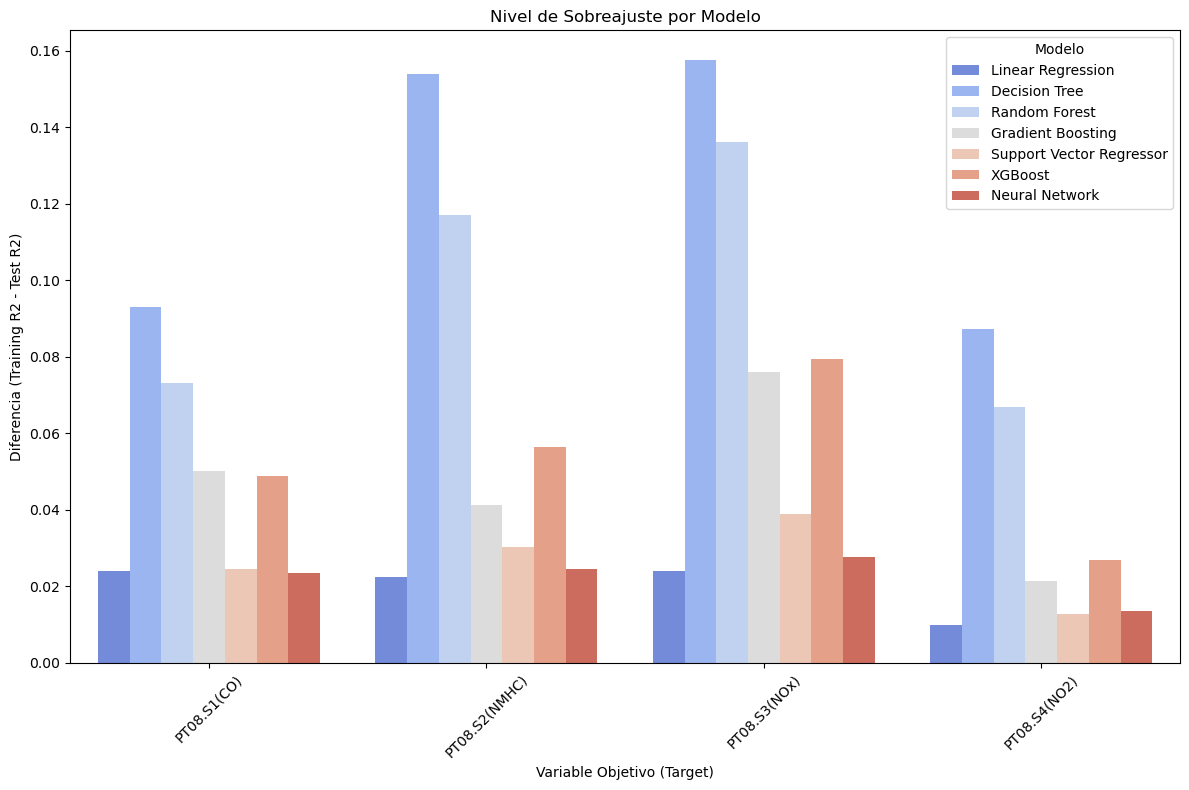

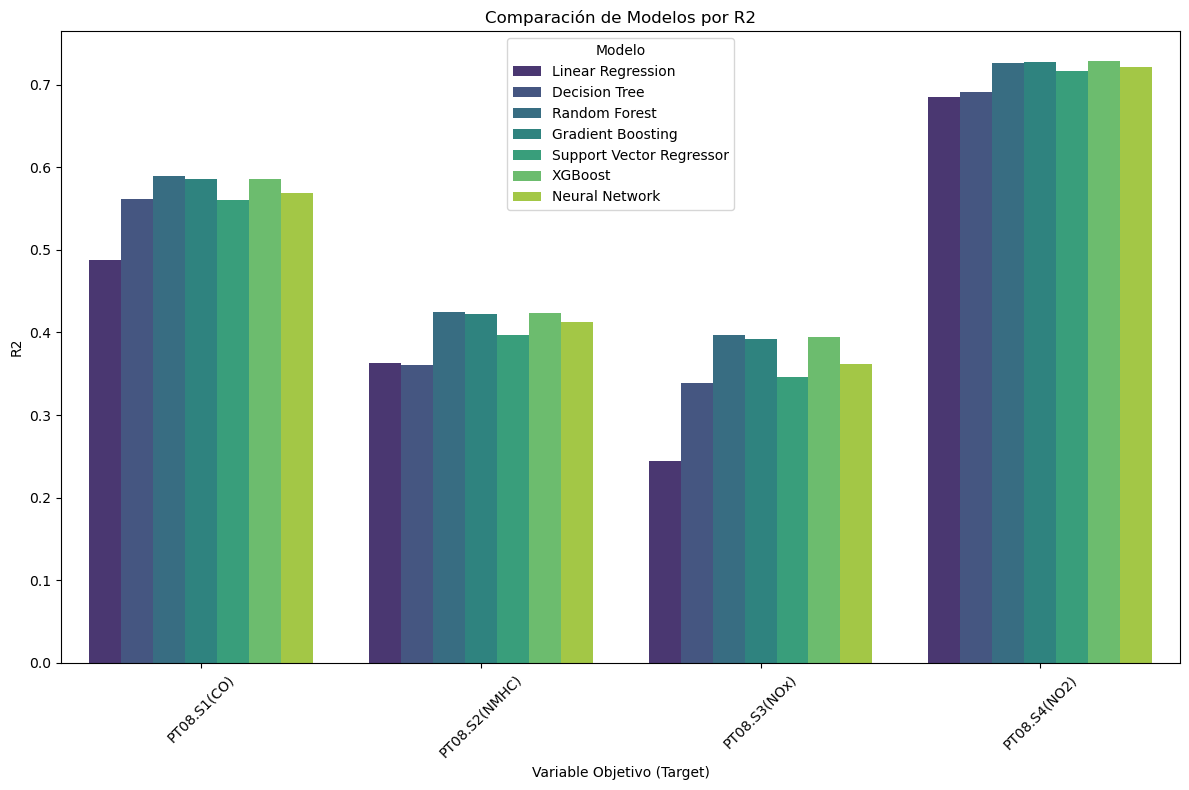

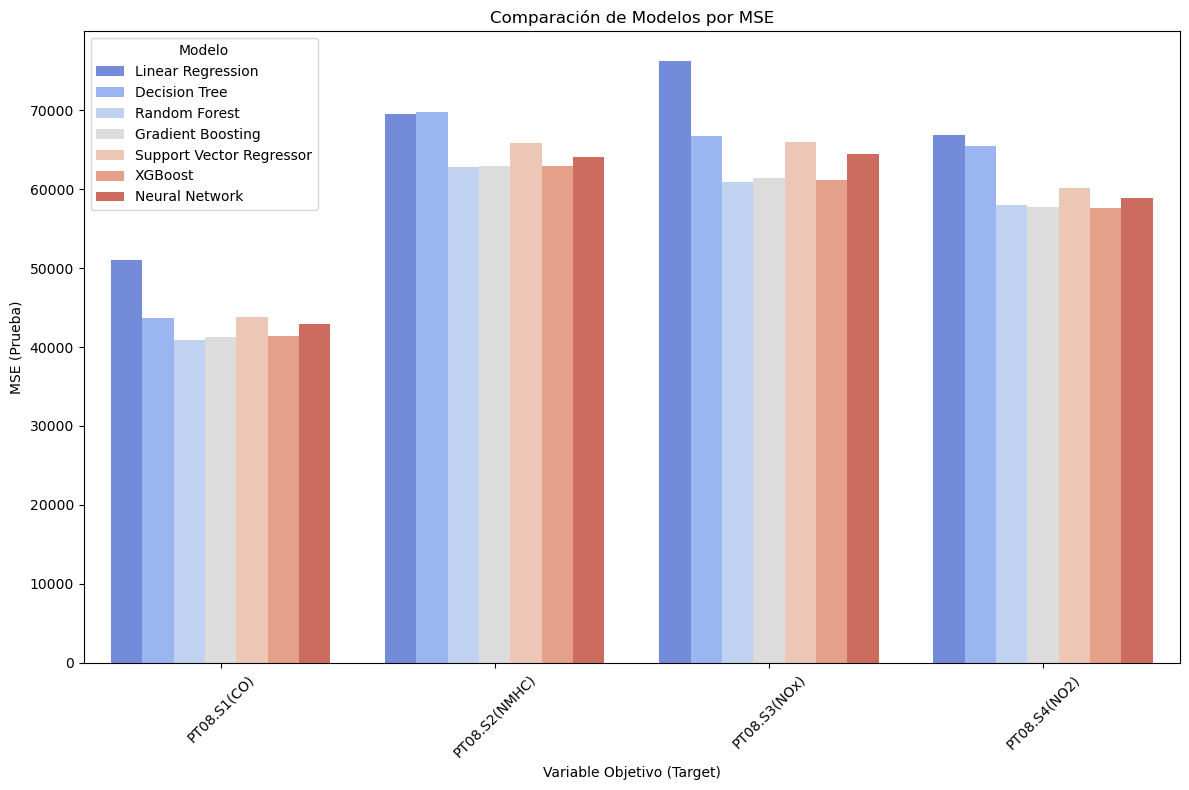

In [20]:

# Visualizar el sobreajuste con un gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='Overfitting', hue='Model', palette='coolwarm')
plt.title("Nivel de Sobreajuste por Modelo")
plt.ylabel("Diferencia (Training R2 - Test R2)")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizar los R2 de prueba
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='R2', hue='Model', palette='viridis')
plt.title("Comparación de Modelos por R2")
plt.ylabel("R2")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizar los MSE de prueba
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='MSE Test', hue='Model', palette='coolwarm')
plt.title("Comparación de Modelos por MSE")
plt.ylabel("MSE (Prueba)")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PARTE DE MIA IMANOL

In [32]:
import joblib

# Cargar el modelo en Python 3
model = joblib.load('modelo_xgb_optimizado.pkl')

# Guardarlo nuevamente en un formato compatible con Python 2 (protocolo 2)
joblib.dump(model, 'modelo_xgb_optimizado_v2.pkl', protocol=2)

['modelo_xgb_optimizado_v2.pkl']